In [1]:
#Imports 
import json
import urllib
from urllib.request import urlopen
import networkx as nx
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import RegexpTokenizer
import re
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import os
import operator
from wordcloud import WordCloud
import pprint
import numpy as np
import operator
import math
import itertools
import community

<h1> THE ONE WHERE WE ANALYSE FRIENDS - Explainer notebook

In this notebook the technical details of how the project is implemented will be introduced. The notebook is divided in four parts, in the <b>Motivation</b> section the main idea behind the project is introduced, in <b>Basic Stats</b> the datasets and how they are pre-processed is introduced, then in <b>Tools Theory and Analysis</b> the three kinds of data analysis done in the project will be explained and the code and the results will be presented. In the last part, <b>Discussion</b> it will be discussed what went well in the project and what could have been better.

<h2>Contents</h2>

<b><a href='#Motivation' style="color:black;">Motivation</a><br>
<a href='#Basic'  style="color:black;">Basic Stats</a><br>
<a href='#Tools'  style="color:black;">Tools Theory and Analysis</a></b>
> <a href='#Network'  style="color:black;">The One With The Network Analysis</a><br>
> <a href='#Storylines'  style="color:black;">The One With The Storylines</a><br>
> <a href='#Text'  style="color:black;">The One With The Text Analysis</a><br>

<b><a href='#Discussion' style="color:black;" >Discussion</a><br></b>





<h1> Motivation</h1> <a name="Motivation"></a>

The central idea of this project is investigation and exploration of the tv-series Friends. Both in regard of networks; who is the most popular character? Which characters are the best friends? Is janice the most unpopular character in the series? which words are most common among all episodes, which episode is the most positive? <br>

<b>What is your dataset? </b><br>
1. Character descriptions of all (or most) characters that were in the series to make the network. This comes from: https://friends.fandom.com/wiki/Category:Friends_Characters
2. Character descriptions are also used to make the sentiment analysis regarding which character is described most positively and negatively
3. Transcripts from the episodes to make wordclouds and sentiment analysis of the episodes.  Comes from here: https://www.springfieldspringfield.co.uk/episode_scripts.php?tv-show=friends
4. Dataset that displays which characters are in storylines with eachother, to see who are the best friends of all the friends. This comes from here: https://github.com/apalbright/Friends/tree/master/raw_data
    
<b>What was your goal for the end user's experience?</b><br>
The hope is that other Friends nerds have some fun exploring the different results from the analysis. It's supposed to be a fun way of getting more details and learning more about the series. 

<h1>Basic stats & Preprocessing <a name="Basic"></a>
<h3>Write about your choices in data cleaning and preprocessing<br></h3>
In this section I will go through the neccessary cleaning and preprocessing that have been done to the data. It wasn't necessary to do any preprocessing to the data set with the storylines, but the character descriptions as well as the episode transcripts took some work to clean.

<h3>Character Descriptions</h3>

The character descriptions was downloaded using the fandom api. This was done in two steps; first a list of all characternames was downloaded, which you can see below: 

In [2]:
all = json.load(urlopen("https://friends.fandom.com/api/v1/Articles/List?expand=1&category=Friends_Characters&limit=1000"))
print(all['items'][0])

{'id': 4413, 'title': 'Aaron Goralnik', 'ns': 0, 'url': '/wiki/Aaron_Goralnik', 'revision': {'id': 68670, 'user': 'Lilyflower422', 'user_id': 26157662, 'timestamp': '1535587587'}, 'comments': 0, 'type': 'article', 'abstract': 'Aaron Litman Goralnik is the son of Janice Litman Goralnik and her husband Sid Goralnik. When...', 'thumbnail': None, 'original_dimensions': None}


Now the character names are used to get and store the character descriptions from the API:

In [3]:
#setting path:
path = "/Users/Camillas/Desktop/Kandidat/socialegrafer/project/characters/"

In [27]:
#Downloading character-pages: 
for i in range(len(all['items'])): 
    id = all['items'][i]['id']
    filename = all['items'][i]['title'].replace("/", "_")
    query = "http://www.friends.fandom.com/api/v1/Articles/AsSimpleJson?id="+str(id)
    wikiresponse = urllib.request.urlretrieve(query, path+filename+".txt")

Because the character descriptions include some "extra categories" like for instance an article about all mothers in the series, there have been made some extra stopwords. After that all characternames are assigned to a list. For forcing uniqueness in the list, it is first converted to a set and then converted to a list again.

In [5]:

characterNames = []
extra_stopwords = ['season', 'appearance', 'relationship', 'characters', 'appearance', 'mothers', 'fathers',
                  'grandmothers','grandfathers','residents','family','aunts','uncles', 'zelner', 'sr.', 'Phoebe Abbott'] 
namesToBeRemoved = []
for i in range(len(all['items'])): 
    name = all['items'][i]['title'].replace("/", "_")
    for word in extra_stopwords:
        if word.lower() in name.lower():
            namesToBeRemoved.append(name)
        characterNames.append(name)
characterNames = [w for w in characterNames if not w in namesToBeRemoved]    
characterNames = set(characterNames)
characterNames = list(characterNames)

<b>Transcripts </b><br><br>
The transcripts data was not downloaded using an api, but just directly as HMTL-pages via urrllib, this means that there were some extra cleaning for removing html-tags and such that were disturbing in the text analysis. Instead only the part with the actual description was saved. This was done using the built in python function for splitting strings. 

In [6]:
directory = os.fsencode(path)

#Initializing and cleaning data: 
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    file = open(path+'/'+filename, "r")
    f = file.read()
    #f = f.split("scrolling-script-container")[2]
    #f = f.split("</div>")[0]
    file = open(path+'/'+filename, "w")
    file.write(f)

<b>Dataset stats</b><br>
<i>What is the total size of your data? (MB, number of rows, number of variables, etc)</i>
1. Character descriptions: 
436 txt files ~ 50 kb pr file 

2. Episode transcripts: 
237 txt file, 10 mb 

3. Character storylines: 
211 kb (see example below)

- What is the network you will be analyzing?
Nodes: 423, edges: 2782

In [7]:
#storylines.head()

<h1>Tools, theory and analysis. <a name="Tools"></a>
<h2> PART ONE: THE ONE WITH THE NETWORK ANALYSIS <a name="Network"></a>
<h2>General cleaning and tokenizing function</h2><br>
A lot of the functions rely on clean, tokenized data - for instance the ones for getting the character names for the network below and the ones used for doing textual analysis  So for that a general cleaning function has been defined. It does several things; <br>
1. Excludes punctuation <br>
2. Excludes digits<br>
3. Tokenizes the text (splits it into a list of words)<br>
4. Sets all words to lower case<br>
5. Remove all stop words (Common words with no special meaning)<br>
6. Remove extra stopwords (in this case just 'br' which is a leftover from the html pages.


In [8]:
#Cleaning text
stop_words = set(stopwords.words('english'))
html_stopwords = ['br']
def clean(text):
    tokens = []
    text = re.sub(r'\B\@\w+','', text)
    text = re.sub(r'\d+', '', text)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if not w in html_stopwords]
    return tokens

<h2> The graph representation
<h3> What, why and how <br></h3>

The main idea with the graph representation that can be seen above, is to get a visual overview of what the structure between the characters look like. For making the structure extra visible, I've made two versions; one containing names (labels) for all characters included in the network and one containing only the main characters.<br>

The network is made as a directed graph, such that it's possible to represent references to and from characters, because this is really interesting for this kind of network. The implementation is made using networkx which also has been used troughout the semester and the plots of the network is made using the ForceAtlas algorithm to set node positions. 


<h3> Implementation

In [9]:
network = nx.DiGraph()
characterNames = list(characterNames)

#Creating nodes: 
for name in characterNames:
    network.add_node(name)

characterNameSet = set([name.split(" ")[0].lower() for name in characterNames])
characterNameDict = {}

#Force dict to contain main characters
characterNameDict['phoebe'] = "Phoebe Buffay"
characterNameDict['rachel'] = "Rachel Green"
characterNameDict['monica'] = "Monica Geller-Bing"
characterNameDict['chandler'] = "Chandler Bing"
characterNameDict['ross'] = "Ross Geller"
characterNameDict['joey'] = "Joey Tribbiani"

#Adding characters to dict 
for name in characterNames: 
    stripped = name.split(" ")[0].lower()
    if stripped not in characterNameDict:
        characterNameDict[stripped] = name

#Addin edges between characters: 
for name in characterNames:
    text = open(path+name+".txt", 'r').read()
    tokens = clean(text)
    tokens = set(tokens)
    intersect = tokens.intersection(characterNameSet) 
    if intersect:
        for val in intersect: 
            network.add_edge(name, characterNameDict[val])

In [10]:
#Undirected graph:
networkUndirected = network.to_undirected()

#Using forceatlas to set coordinates
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=5,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.001,
                          strongGravityMode=False,
                          gravity=5,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(networkUndirected, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:04<00:00, 409.92it/s]

BarnesHut Approximation  took  1.28  seconds
Repulsion forces  took  2.98  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


In [11]:
#Giving main characters special colors: 
main_characters = ["Phoebe Buffay", "Rachel Green", "Monica Geller-Bing", "Chandler Bing", "Ross Geller","Joey Tribbiani"]
node_color = []
show_label = {}

for node in network.nodes(data=True):
    if node[0] in main_characters:
        node_color.append('#f4bc42')
        show_label[node[0]]=node[0]
    else: 
        node_color.append('#247f2e')

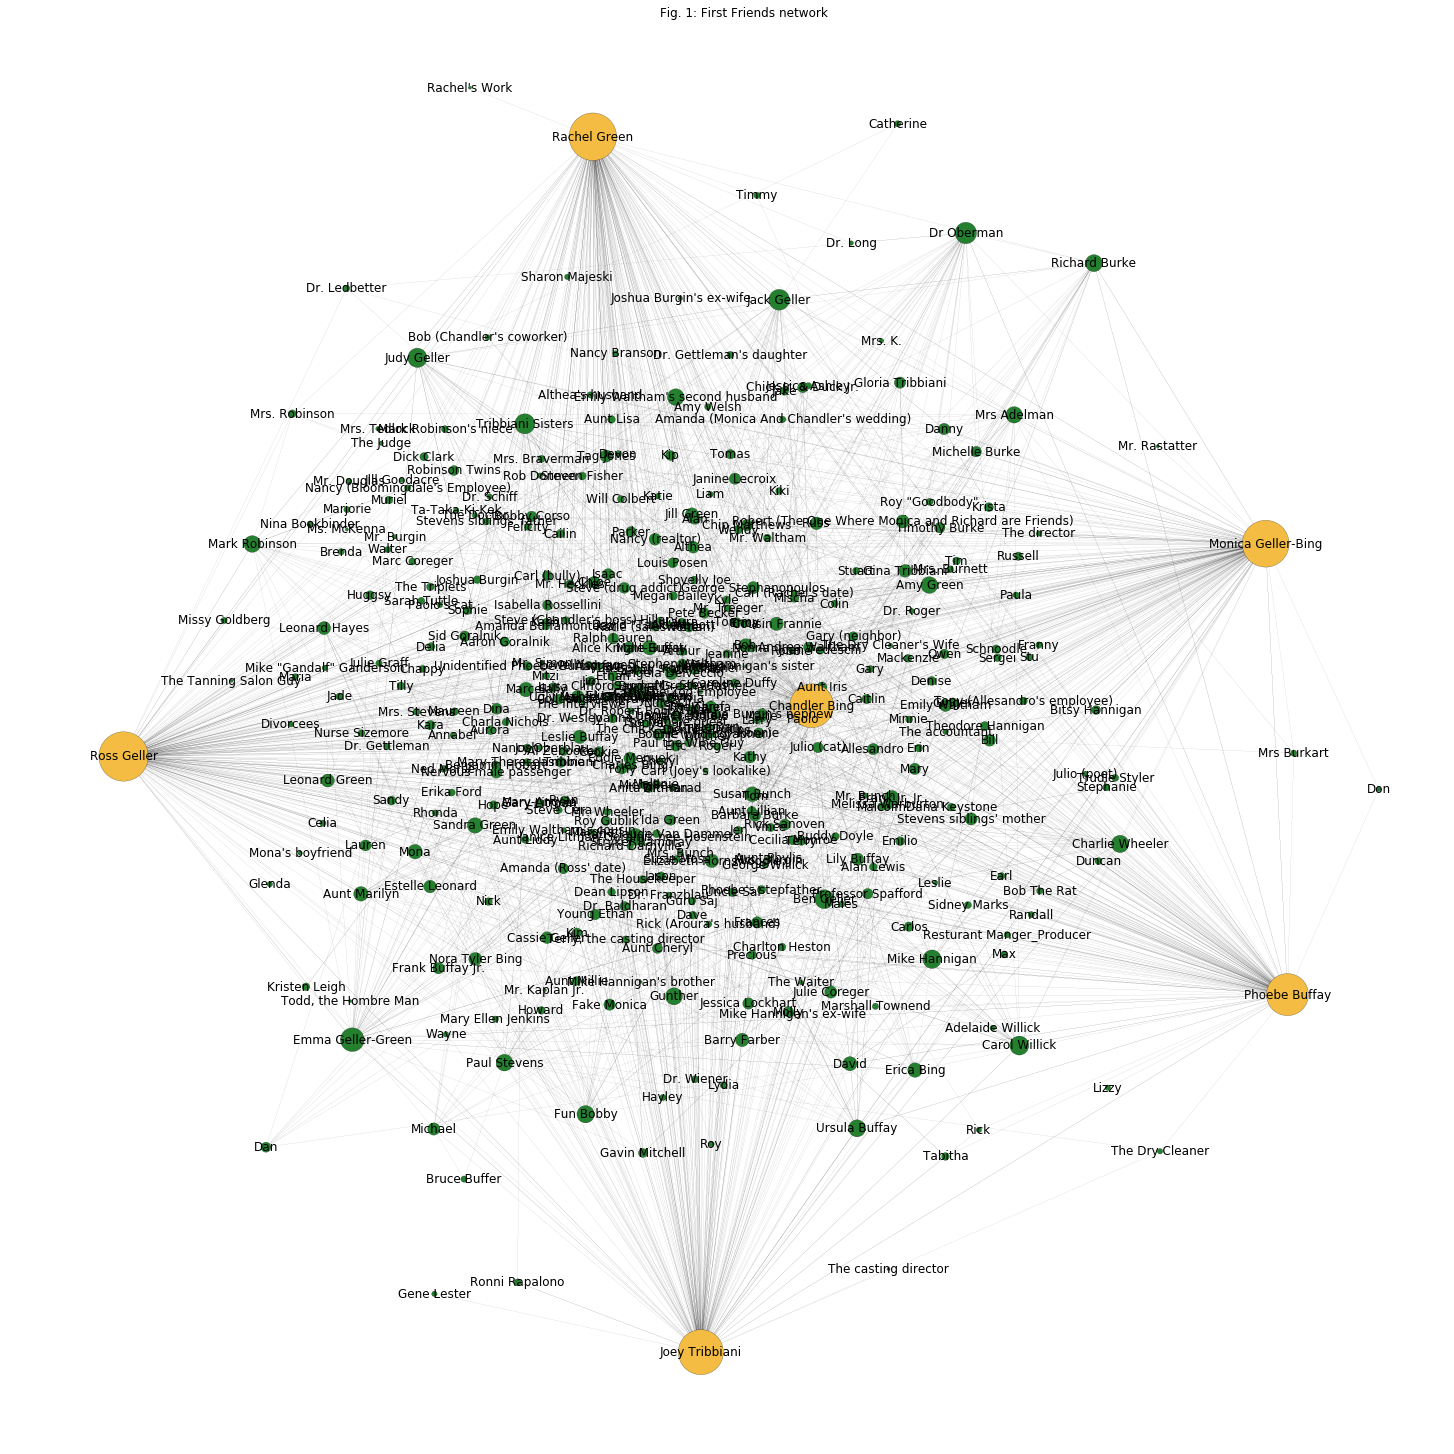

In [12]:
plt.figure(figsize=(20,20))
plt.title("Fig. 1: First Friends network")

pos = nx.spring_layout(network,k=0.15,iterations=20)
degree_sequence = [d for n, d in network.degree()]
nx.draw_networkx(network,positions,linewidths=0.2, edgecolors='#000000',node_color=node_color, node_size=[v * 10 for v in degree_sequence], 
                 with_labels=True, width=0.05, arrows=False)
#nx.draw_networkx_labels(network,positions,show_label,font_size=16)

plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

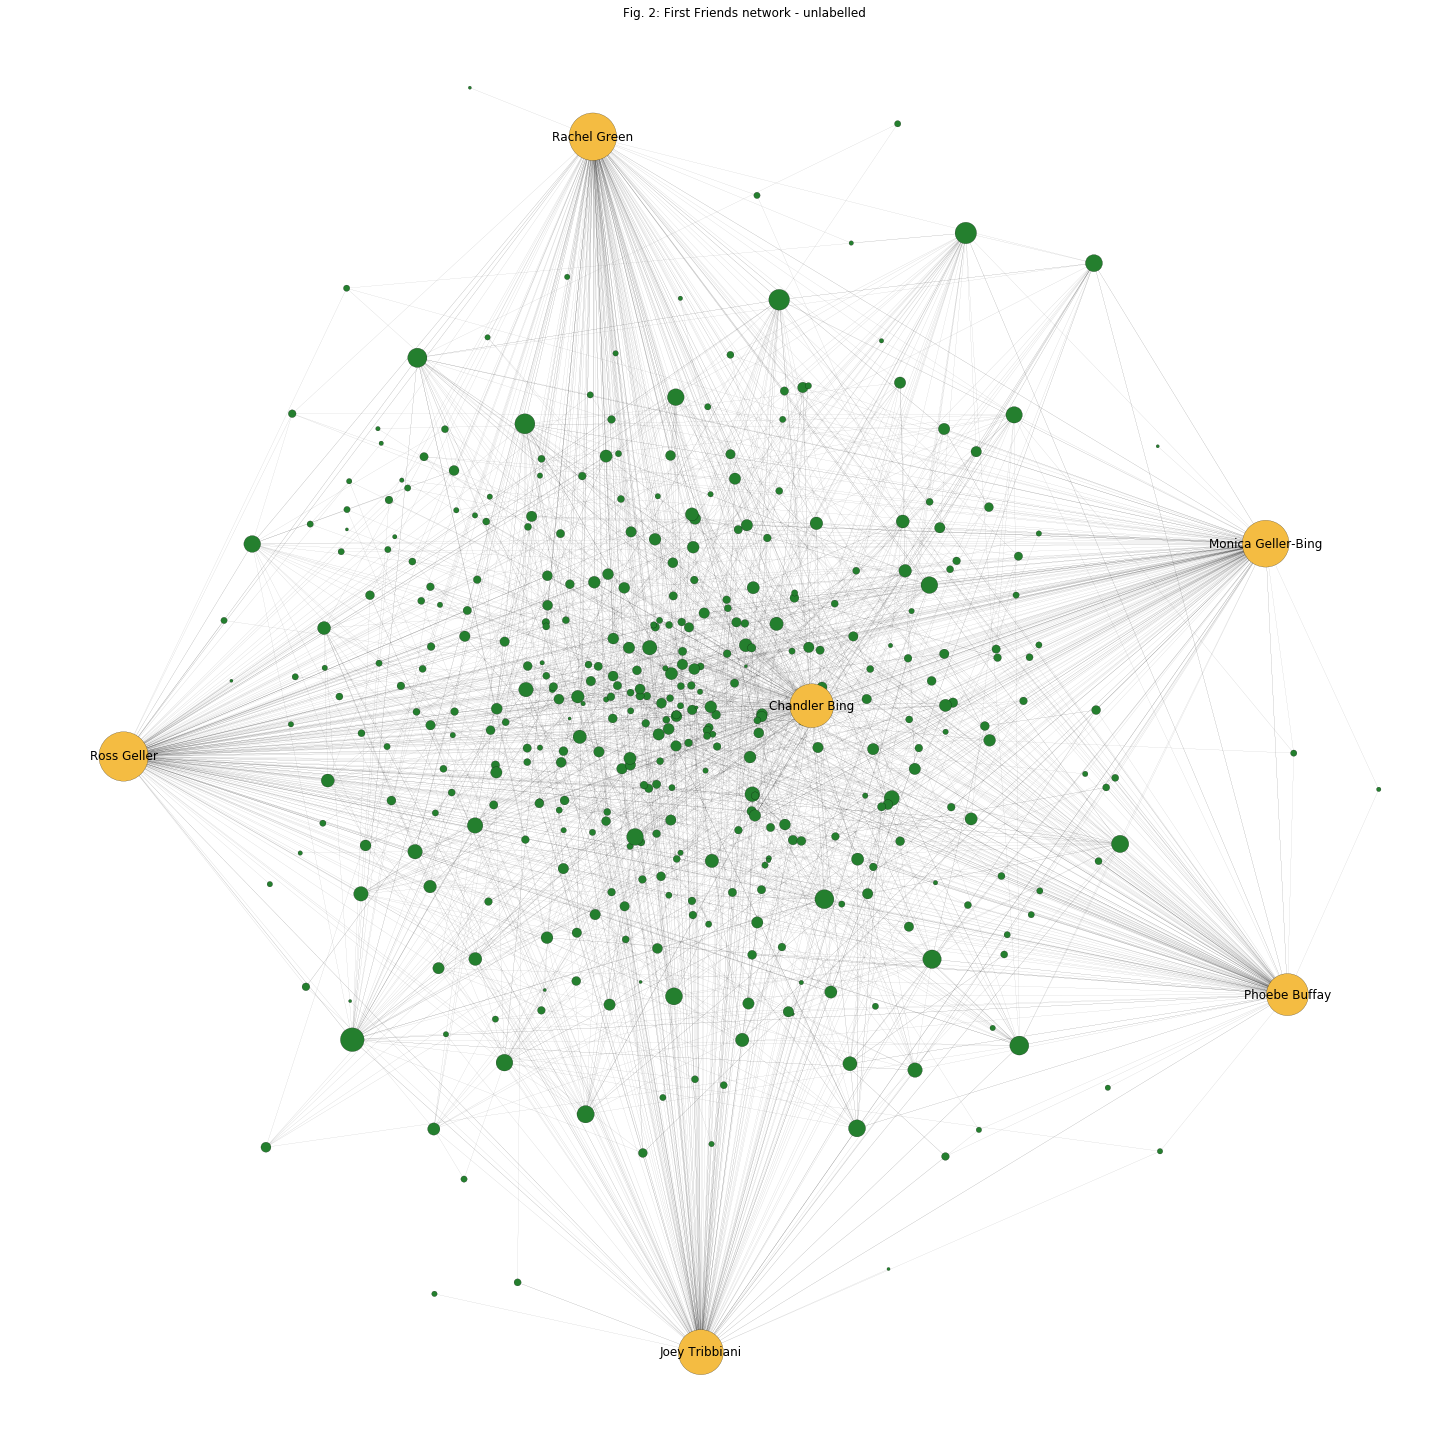

In [13]:
plt.figure(figsize=(20,20))
plt.title("Fig. 2: First Friends network - unlabelled")

pos = nx.spring_layout(network,k=0.15,iterations=20)
degree_sequence = [d for n, d in network.degree()]
nx.draw_networkx(network,positions,linewidths=0.2, edgecolors='#000000',node_color=node_color, node_size=[v * 10 for v in degree_sequence], 
                 with_labels=False, width=0.05, arrows=False)
nx.draw_networkx_labels(network,positions,show_label,font_size=12)

plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<h3> Comments to result</h3>

A very characterstic thing about the network is that each character is a hub in the network. Which makes sense because all characters introduced in the series will have to have some kind of relation to one of the main characters


<h2> Degree distribution </h2>
<h3> What, why and how </h3>
The degree distribution is a plot that displays all degrees in the network sorted. The degree distribution can tell a lot about which kind of network that you're working with. The degrees of the network can be obtained with a method call toy networkx. 

<h3> Implementation

In [14]:
degree_sequence = [d for n, d in network.degree()]

deg = degree_sequence
degCount = Counter(deg)
deg, cnt = zip(*degCount.items())

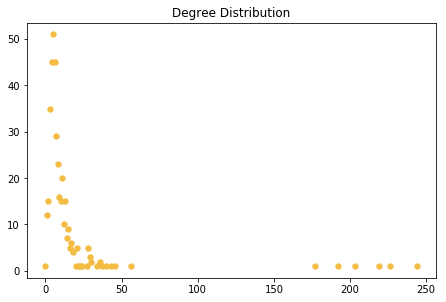

In [15]:
#Plotting: 
plt.title("Degree Distribution")
plt.scatter(deg, cnt,  color='#f4bc42', linewidth=0.3)
plt.tight_layout(pad=0)
plt.show()

<h3> Comments to result</h3>
The plot above displays that a lot of the nodes in the network have degrees of 50 or less, while 6 nodes have more than 150. Without investigating further it's pretty safe to say that these 6 nodes are our 6 main characters. When the distribution looks like this, it's a reflection of a network with hubs in it - meaning few nodes are "center" for other nodes.

<h2> Centrality measures
<h3> What, why and how </h3>
A part of the project has been to use different measures to find out who's the most popular characcter of the main characters. One of the ways to measure this is by using the centrality measures of the network, which can give an idea of which nodes are most influential in a network. I've used the following four measures:<br><br>
1. <b>In-degree centrality: </b> <br>
The in-degree centrality is a measure of how many people "know" a character. So in regards of the character pages, it's determined by the references to other characters on the character pages. <br><br>
2.  <b>Out-degree centrality: </b><br> The out-degree is the opposite of the in-degree centrality. So in this measure we look at how many characters a certain charcterpage has references to. <br><br>
3. <b>Betweeness centrality:</b> <br> The betweenness centrality is based on shortest paths. A <i>shortest path</i> is the number of edges that needs to be traversed in order to get from node A to node B. For all nodes pairs in a network, there exists a shortest path. The betweeness centrality is then a measure of how many times a node is a part of a shortest path. <br> <br>
4. <b>Eigenvector centrality:</b> <br> The main idea with eigenvector centrality is that nodes that are connected with "high scoring" nodes are more important than nodes that are node connected to such nodes. So a node with a high score is more powerful in a network, than a node with a lower score.<br><br>


<h3> Implementation
<h4> Eigenvector centrality

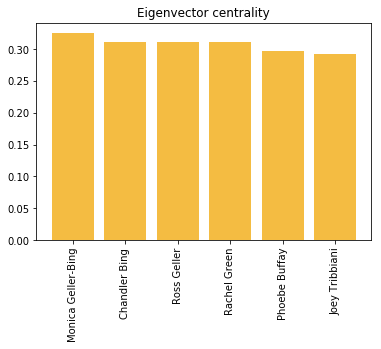

In [16]:
central = nx.eigenvector_centrality(network,max_iter=500 )
sorted_central = sorted(central.items(), key=operator.itemgetter(1), reverse=True)[0:6]
degCount = Counter(sorted_central)
deg, cnt = zip(*degCount.items())

names = [i[0] for i in sorted_central]
values = [i[1] for i in sorted_central]

#Plotting: 
plt.title("Eigenvector centrality")
plt.bar( names, values, color='#f4bc42', linewidth=0.5, label='degree distribution')
plt.xticks(rotation=90)
plt.show()

<h4> In-degree centrality

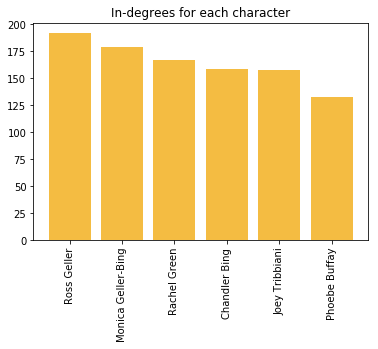

In [17]:
inDegree = network.in_degree(network)
sortedDegree =(sorted(inDegree, key=lambda x: x[1], reverse=True))[0:6]
names = [i[0] for i in sortedDegree]
values = [i[1] for i in sortedDegree]

#Plotting: 
plt.title("In-degrees for each character")
plt.bar( names, values, color='#f4bc42', linewidth=0.5, label='degree distribution')
plt.xticks(rotation=90)
plt.show()

<h4> Out-degree centrality

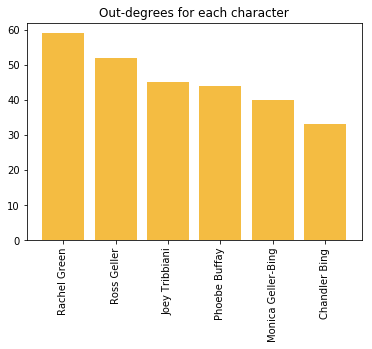

In [18]:
outDegree = network.out_degree(network)
sortedDegree =(sorted(outDegree, key=lambda x: x[1], reverse=True))[0:6]
names = [i[0] for i in sortedDegree]
values = [i[1] for i in sortedDegree]

#Plotting: 
plt.title("Out-degrees for each character")
plt.bar( names, values, color='#f4bc42', linewidth=0.5, label='degree distribution')
plt.xticks(rotation=90)
plt.show()

<h4> Betweenness centrality

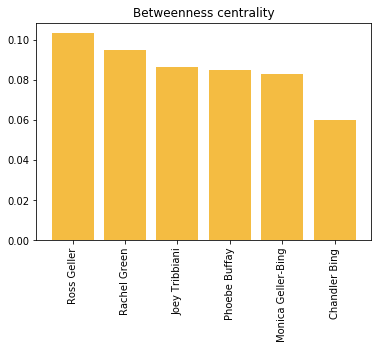

In [19]:
between = nx.betweenness_centrality(network)
sorted_between = sorted(between.items(), key=operator.itemgetter(1), reverse=True)[0:6]
names = [i[0] for i in sorted_between]
values = [i[1] for i in sorted_between]

#Plotting: 
plt.title("Betweenness centrality")
plt.bar( names, values, color='#f4bc42', linewidth=0.5, label='degree distribution')
plt.xticks(rotation=90)
plt.show()

<h3> Comments to result</h3>
The different centrality measures also have different outcomes, meaning even though Ross is the one with the highest in-degree, rachel is the one  with the highest out-degree and Monica the one with highest eigenvector centrality. 
This means that there's no direct answer to who's the most popular character, it depends on what you want to know. I this case a easy way to choose could be to look at the one with the highest in-degree, as this is the amount of people that have references to the character - in this case Ross is most popular.

In [20]:
sortedDegree = (sorted(network.degree, key=lambda x: x[1], reverse=False))[0:20]
print(sortedDegree)

[('The female guest', 0), ("Rachel's Work", 1), ('The casting director', 1), ('Mr. Rastatter', 1), ('Ms. McKenna', 1), ('Dr. Wesley', 1), ("Mike Hannigan's brother", 1), ("Mike Hannigan's ex-wife", 1), ('Todd, the Hombre Man', 1), ('The Tanning Salon Guy', 1), ("Mike Hannigan's sister", 1), ('The Thief', 1), ('Mr. Kaplan Jr.', 1), ("Mona's boyfriend", 2), ('Mrs. K.', 2), ("Joshua Burgin's ex-wife", 2), ('The Judge', 2), ('Dr. Long', 2), ('Mrs. Tedlock', 2), ('Don', 2)]


<h2> Community detection
<h3> What, why and how </h3>
Based on the hubs before and the general structure of the network I had an idea that the network might contain some communities. To investigate this idea further community detection was made using the Louvain algorithm. <br> <br>
The main idea with the Louvain algorithm is to optimize modularity. Modularity is a value between -1 and 1 used for defining how well a network partitions, the better the value the better the grouping of the nodes.
The library "community" is utilised to get the best partitions of the character network based on this algorithm. 


References:
https://en.wikipedia.org/wiki/Louvain_Modularity
https://en.wikipedia.org/wiki/Modularity_(networks)

<h3> Implementation </h3>

In [21]:
networkUndirected = network.to_undirected()
isolates = nx.isolates(networkUndirected)
networkUndirected.remove_nodes_from(list(isolates))
partition = community.best_partition(networkUndirected)

size = float(len(set(partition.values())))

In [67]:
community.modularity(partition, networkUndirected)

0.3863627267384421

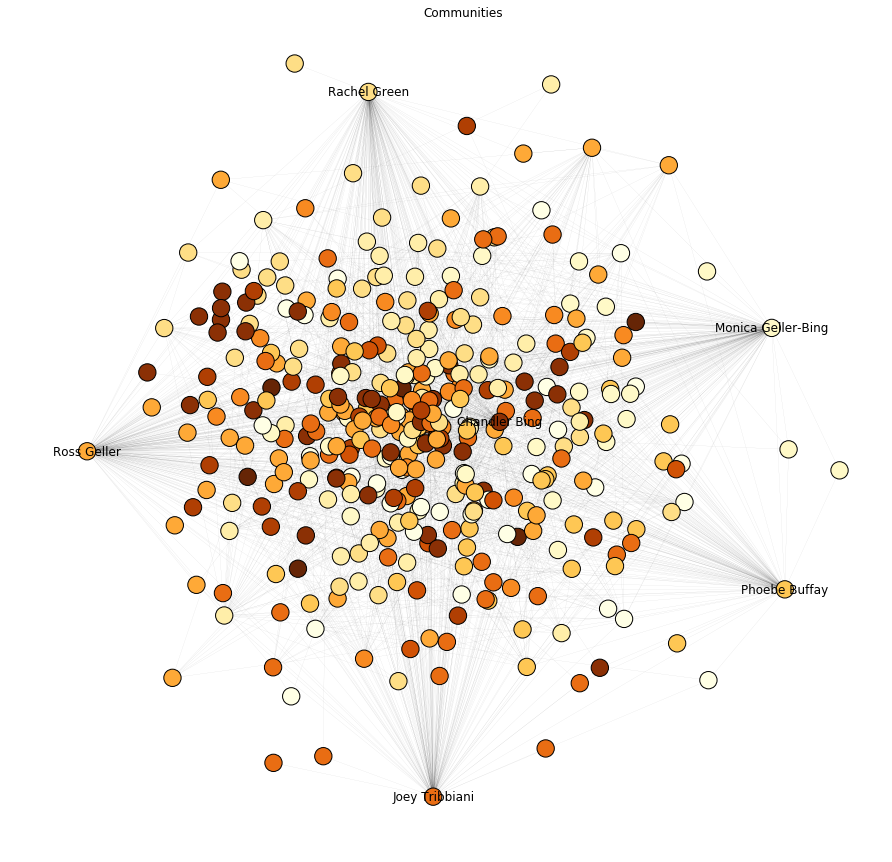

In [64]:

count = 0.

plt.figure(3,figsize=(15,15)) 
values = [partition[n] for n in networkUndirected.nodes()]

nx.draw_networkx_nodes(networkUndirected, positions, node_color=values, 
                         with_labels=False, node_size=300, cmap=plt.cm.YlOrBr, edgecolors='#000000')

nx.draw_networkx_edges(networkUndirected, positions, alpha=0.3,  width=0.1,)
nx.draw_networkx_labels(networkUndirected,positions,show_label,font_size=12)
plt.title("Communities")
plt.axis('off')
plt.show()

In [66]:
partitionDict = {}
for key, val in partition.items():
    if val not in partitionDict:
        partitions = []
        partitions.append(key)
        partitionDict[val] = partitions
    else: 
        partitions = partitionDict[val]
        partitions.append(key)
        partitionDict[val] = partitions

for key, val in partitionDict.items():
    degrees = sorted(network.degree(partitionDict[key]), key=lambda x: x[1], reverse=True)[0:10]
    partitionDict[key] = degrees
    
#for i in range(len(partitionDict.keys())):
    #print(pd.DataFrame.from_dict(partitionDict[i]))

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


<h3> Comments to result</h3>
The plot above shows that the main characters are all divided into each of their own community, there are 12 communities in total - so there's also communities that doesn't consist of any of the main characters (see the results on the webpage or run the lines that are commented out above (the output is pretty long, so not used right now). Overall I think the partitions are pretty good, but there are some groupings that are hard to explain. The modularity value of the partitions is 0.3 which is pretty good. 

<h1> PART TWO: THE ONE WITH THE STORYLINES <a name="Storylines"></a>
<h3> What, why and how </h3>
In this part the storylines dataset, that can be seen below is used for calculating different stats. 
The dataset is made such that each character is mapped to a number. So looking at the dataset below, 
a number standing alone means an individual storyline, while combined numbers means grouped storylines.
The mapping is this: <br>
1 = Chandler 2 = Joey 3 = Monica 4 = Phoebe 5 = Rachel 6 = Ross



In [24]:
storylines = pd.read_csv("/Users/Camillas/Desktop/Kandidat/socialegrafer/project/network1/friendsdata.csv")

In [25]:
storylines.head()

,epseason,epnum,epname,dynamics
0,1,1,The One Where Monica Gets a Roommate,3
1,1,1,The One Where Monica Gets a Roommate,5
2,1,1,The One Where Monica Gets a Roommate,56
3,1,1,The One Where Monica Gets a Roommate,126
4,1,2,The One with the Sonogram at the End,3


<h2> Individual storylines </h2>
<h3> What, why and how </h3>
First measure is to figure out who has most individual storylines. For this the value_counts methods from pandas has been utilised.

In [26]:
counts = storylines['dynamics'].value_counts()

In [27]:
characters = [] 
characterNames = ["Chandler", "Joey", "Monica", "Phoebe", "Rachel","Ross"]
for i in range(1,7):
    characters.append(counts[i])

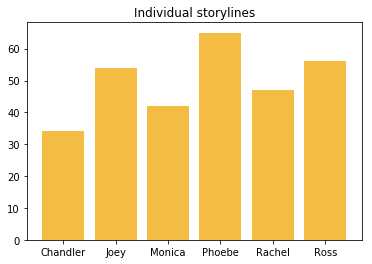

In [28]:
#Plotting: 
plt.title("Individual storylines")
plt.bar( characterNames, characters, color='#f4bc42', linewidth=0.5)
plt.show()

<h2> Grouped storylines </h2>
<h3> What, why and how </h3>
Next measure: Finding out which characters have most storylines togethers (finding the best friends of Friends). This is also done using the count from before, just removing the individual counts. 

In [29]:
countDict = counts.to_dict()

In [30]:
for i in range(1,7):
    del countDict[i]

In [31]:
highestCounts = sorted(countDict.items(), key=operator.itemgetter(1), reverse=True)[0:10]
dynamic, cnt = zip(*highestCounts)

<BarContainer object of 10 artists>

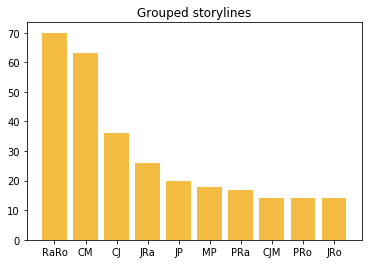

In [32]:
characterDict = {}
characterDict['1'] = "C"
characterDict['2'] = "J"
characterDict['3'] = "M"
characterDict['4'] = "P"
characterDict['5'] = "Ra"
characterDict['6'] = "Ro"
charNames = []

for val in dynamic:
    names = ''
    for l in str(val):
        names += characterDict[l]
    charNames.append(names)

plt.title("Grouped storylines")
plt.bar( charNames, cnt, color='#f4bc42', linewidth=0.5)

<h2> Total count of storylines</h2>
<h3> What, why and how </h3>
To find out which character is "most popular" in the screen writers eyes a count of how many storylines each character has in total was made.

In [33]:
counterDict = {}
for i in range(1,7):
    counterDict[str(i)] = 0

counter = 0    
for val in storylines['dynamics']:
    for l in str(val):
        counterDict[l] += 1

<BarContainer object of 6 artists>

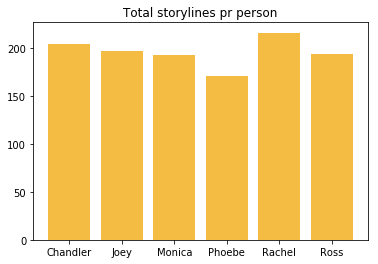

In [34]:
cnt = counterDict.values()
#Plotting: 
plt.title("Total storylines pr person")
plt.bar( characterNames, cnt, color='#f4bc42', linewidth=0.5)

<h2> Weighted network</h2>
<h3> What, why and how </h3>
This one is a bit more complicated that the others in this section. I wanted to visualise the relations between the characters in terms of the amount of storylines they have together. This is done by creating a network with weighted edges. So for each time they have a storyline together the weight of their edges are increased by one. This is both when they are only two in a storyline, but also if they are more, which means that the different combinations have to be taken into account in order to get the right count of the storylines. <br>
The tools for making this is again the networkx library which also support adding edge weights. And then in general a looot of dictionaries :) 


In [35]:
#Initialising all combinations of characters in a dict all with value 0. 
networkWeightDict = {}
networkWeightDict[12] = 0
networkWeightDict[13] = 0
networkWeightDict[14] = 0
networkWeightDict[15] = 0
networkWeightDict[16] = 0
networkWeightDict[23] = 0
networkWeightDict[24] = 0
networkWeightDict[25] = 0
networkWeightDict[26] = 0
networkWeightDict[34] = 0
networkWeightDict[35] = 0
networkWeightDict[36] = 0
networkWeightDict[45] = 0
networkWeightDict[46] = 0
networkWeightDict[56] = 0

#Adding counts for the first grouped storylines: 
for key, val in countDict.items():
    if key in networkWeightDict:
        networkWeightDict[key] = val

In [36]:
#Cleaning dictionaries after adding counts above (so they're not counted twice)
for i in networkWeightDict.keys():
    if i in countDict:
        del countDict[i]
for i in range(1,7):
    if i in countDict:
        del countDict[i]

In [37]:
#Looking at all combinations of grouped storylines and adding wait to dictionary
for key, val in countDict.items():
    comb = itertools.combinations(str(key), 2)
    for i in comb:
        k = int(i[0]+i[1])
        if k in networkWeightDict:
            networkWeightDict[k] += val

In [38]:
#Creating the network with the edgeweights
storyLines = nx.Graph()

#Adding nodes
for i in range(1,7):
    storyLines.add_node(i)
    
#Adding edges and weights
for i in range(1,7):
    for j, k in networkWeightDict.items():
        if str(j)[0] == str(i):
            splitted = str(j)[1]
            storyLines.add_edge(i, int(splitted), weight=k)



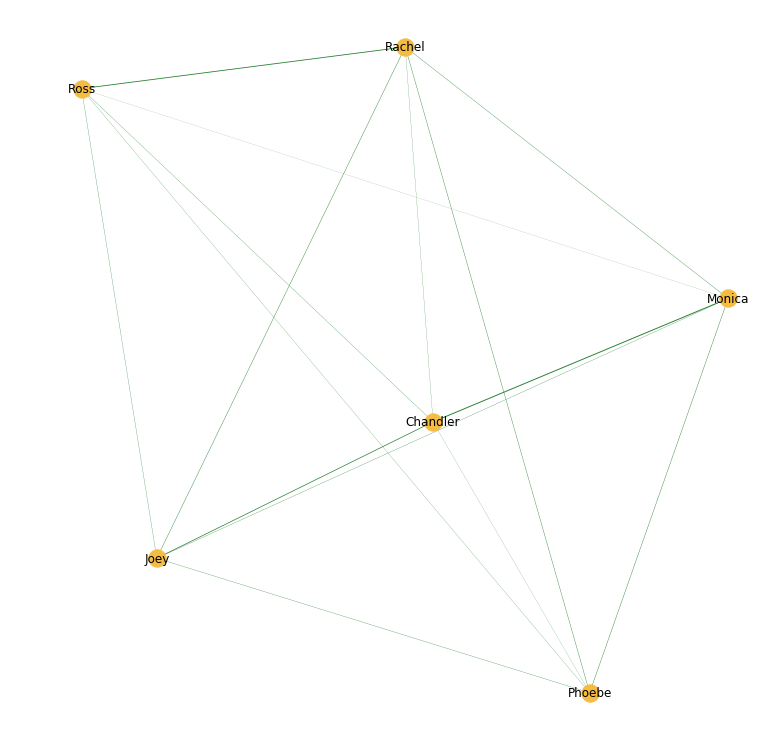

In [39]:
#Plotting the weighted network

plt.figure(figsize=(10,10))
edges = storyLines.edges()
weights = [storyLines[u][v]['weight']*0.01 for u, v in edges]
mapping = {1: "Chandler", 2:"Joey", 3:"Monica", 4:"Phoebe",5:"Rachel",6:"Ross"}
new = nx.relabel_nodes(storyLines,mapping)

nx.draw(new, edges=edges, node_color='#f4bc42', edge_color="#247f2e", width=weights, with_labels=True)

<h1> PART THREE: THE ONE WITH THE TEXT ANALYSIS <a name="Text"></a></h1>
<h2> Sentiment Analysis</h2>
<h3> What, why and how </h3>
I'm using sentiment analysis for two different kinds of data; character descriptions to see which characters are describes most positively and the episode transcripts for seeing the sentiment of the episodes over time. <br>

Because I'm going to be calculating sentiment several times, I've made a general function for it. The function is based on the algorithm from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752. The algorithm is a lexicon based algorithm, which use a lexicon/dataset the authors of the paper references have made using amazons mechanical turk, you can see what this dataset looks like below. Each word in the dataset has a so-called happiness average, so the way sentiment of a text is calculated is by checking for each word in the text if the word is in the data set, and if so the sentiment of the text is increased with the value of that word from the data set and finally the sentiment is found by taking the mean of the sentiment calculated.

<h3> Implementation</h3>

In [40]:
wordlist = pd.read_csv("/Users/Camillas/Downloads/Data_Set_S1.txt", sep='\t', header=2)
wordlist = wordlist[['word', 'happiness_average']].copy()
wordDict = {}
for index, row in wordlist.iterrows():
    wordDict[row['word']] = row['happiness_average']
wordlist.head()    

,word,happiness_average
0,laughter,8.50
1,happiness,8.44
2,love,8.42
3,happy,8.30
4,laughed,8.26


In [41]:
def calculateSentiment(tokens):
    sentiment=0
    counter = 0
    tokens = Counter(tokens)
    for word,count in tokens.items(): 
        if word in wordDict: 
            sentiment += wordDict[word]
            counter += 1
    return sentiment/counter;  

<h3> Calculating sentiment of the character descriptions </h3>

In [42]:
sentDict = {}
mainSentDict = {}
mainCharacterNames = ["Monica Geller-Bing", "Chandler Bing", "Rachel Green", 
                      "Ross Geller", "Phoebe Buffay", "Joey Tribbiani"]

for name in characterNames:
    text = open(path+"/"+name+".txt", 'r').read()
    tokens = clean(text)
    sentDict[name] = calculateSentiment(tokens)
    
for name in mainCharacterNames:
    text = open(path+"/"+name+".txt", 'r').read()
    tokens = clean(text)
    mainSentDict[name] = calculateSentiment(tokens)
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Camillas/Desktop/Kandidat/socialegrafer/project/characters//Chandler.txt'

In [ ]:
sortedDictPos = sorted(sentDict.items(), key=operator.itemgetter(1), reverse=True)[0:6]
sortedMainPos = sorted(mainSentDict.items(), key=operator.itemgetter(1), reverse=True)[0:6]

print(pd.DataFrame(sortedDictPos, columns=["Name", "Sentiment"]))

In [ ]:
print(pd.DataFrame(sortedMainPos, columns=["Name", "Sentiment"]))

<h3> Comments to result</h3>
There are two versions of this analysis. The first one is created based on chararacter descriptions for all characters in the series, while the one on the right is only for the main characters. What it displays is that if all character are included, none of the main characters is in the top 6. Actually it looks pretty random who is included in the top 6. So the other one is just to see which sentiment scores the characters has received. It's quite funny to see that the results are totally different than what I would expect. As this is an averaged result there are appearently more positive words for Mary These Tribbiani than for the main characters.


<h3>Calculating sentiment for the episodes </h3>

In [ ]:
path = "/Users/Camillas/Desktop/Kandidat/socialegrafer/project/transcripts"
directory = os.fsencode(path)
transDict = {}
transOrg = {}

#Initializing and cleaning data: 
#Adding to dict: 
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    file = open(path+'/'+filename, "r")
    f = file.read()
    tokens = clean(f)
    transDict[filename] = calculateSentiment(tokens)
    transOrg[filename] = tokens

In [ ]:
Pos = sorted(transDict.items(), key=operator.itemgetter(1), reverse=True)[0:3]

print(pd.DataFrame(Pos, columns=["Episode", "Sentiment"]))

In [ ]:
Neg = sorted(transDict.items(), key=operator.itemgetter(1))[0:3]

print(pd.DataFrame(Neg, columns=["Episode", "Sentiment"]))

In [ ]:
#Plotting: 
plt.figure(figsize=(50,10))
plt.title("Sentiment for all episodes")

plt.bar(transDict.keys(),transDict.values(), color='#f4bc42',label='degree distribution')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylim(5, 6) 
plt.show()

<h3> Comments to result</h3>
So in the plot above you can see the calculated sentiment for each episode in the series. All numbers vary between 5.5 and 6 - therefore the y-scale is corrected according to this - so it's easier to see the differences in sentiment. But the result is not so interesting by itself, it's more interesting to look at the three most positive and least positive episodes found above the plot.

<h2> Term frequency–inverse document frequency (tf-idf)<h/2>
<h3> What, why and how </h3>
Another interesting thing to do in terms of text analysis is to see which words are more important in a given text. For instance I'm going to use it to find the most important words in the most positive and least positive episode that I found above. <br>
All words in a given text are given a score by finding the term frequency and then they're kind of evened out by the document frquency, such that words that in general occur often are given less value. The algorithm basically contains three steps: <br><br>
1. <b>Calculate tf:</b><br> this is the amount of times each word occur in a text<br><br>
2. <b>Calculate idf:</b><br> This is the amount of times a words occur in all documents divided by the number of documents in total.<br><br>
3. <b>Calculate tf-idf:</b><br> For each word tf-idf is calculated by multiplying the words tf-value with the words idf-value<br><br>




In [ ]:
#calculate tf: 
def getTf(tokens): 
    tf = {}
    wordCounts = Counter(tokens)
    for word, count in wordCounts.items():
        tf[word] = count
    return tf    
    
#Helper function for idf: 
def computeNumberOfDocuments(word): 
    counter=0; 
    for key, val in transOrg.items():
        if word in val:
            counter+=1
    return counter    

def getIdf(tokens, N):
    idf = {}
    for word in tokens:
        idf[word] =  math.log(N/computeNumberOfDocuments(word))
    return idf    
        
#Calculating tf-idf:
def getTfIdf(tokens, N):
    tf = getTf(tokens)
    idf = getIdf(tokens, N)
    tfidf = {}
    for key, val in tf.items():
        tfidf[key] = idf[key] * val
    return tfidf   

In [ ]:
file = open(path+'/'+"s07e22.txt", "r").read()
tokens = clean(file)
tfidf = getTfIdf(tokens, len(transOrg))

In [ ]:
wordCloudPositive = ''

for key, val in tfidf.items(): 
    for i in range(int(val)):
        wordCloudPositive += str(key) + ' '

<h3> Calculating tf-idf for the most positive episode in Friends </h3>

In [ ]:
wordcloud1 = WordCloud(collocations = False, background_color='white', width=800, height=400).generate(wordCloudPositive)
plt.figure( figsize=(20,10), facecolor='w')
plt.imshow(wordcloud1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<h3> Comments to result</h3>

There are two main stories in "The One With Chandlers Dad" which is the episode that the wordcloud is showing, first one is of course about Chandlers dad. Chandler and Monica decides to go visit Chandlers dad, and invite him/her to their wedding. This does not seem to have a high impact on the wordcloud though.. But the name Garibaldi does belong to the piano man playing for Chandlers dad. Besides that the episode is about Rachel finding out why she's never allowed to borrow Monica's porsche, forcing Ross to let her drive and getting a ticket. This is reflected pretty obviously in the wordcloud. <br> So based on this I think the wordcloud captures the important themes of the episode really well.

<h3> Calculating tf-idf for the least positive episode in Friends </h3>

In [ ]:
file = open(path+'/'+"s06e04.txt", "r").read()
tokens = clean(file)
tfidf = getTfIdf(tokens, len(transOrg))

In [ ]:
wordCloudNegative= ''

for key, val in tfidf.items(): 
    for i in range(int(val)):
        wordCloudNegative += str(key) + ' '

In [ ]:
wordcloud2 = WordCloud(collocations = False, background_color='white', width=800, height=400).generate(wordCloudNegative)
plt.figure( figsize=(20,10), facecolor='w')
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<h3> Comments to result </h3>
In "The One Where Joey Loses His Insurance" the main story is that Joey loses his insurance and right after that he gets a hernia causing him a great deal of pain. This is also the episode where Ross start a new job as a teacher and fakes a british accent because he's nervous. <br> <br>
In general tf-idf is a really good tool for finding the most important words.


<h1> Discussion <a name="Discussion"></a>